In [0]:
import cv2
import numpy as np
from skimage.filters import frangi, sobel
from matplotlib import pyplot as plt
import pandas as pd
from scipy.stats import moment
from google.colab.patches import cv2_imshow

from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout
from keras import metrics

In [68]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Część na 3.0

In [0]:
def show_image(img, title="test"):
    cv2_imshow(img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

## Wczytanie zdjęcia

In [0]:
image_size = 100
#blada gałka oczna na czarnym tle
#image = cv2.imread('zdjecia/2_good.JPG') # 11.42 / 10.99

#bardziej czerwona głka oczna na czrnym tle
#image = cv2.imread('zdjecia/8_good.JPG') # 21.93 / 21.25

#duża pomarańczowa gałka oczna na czarnym tle
image = cv2.imread('/content/drive/My Drive/Colab Notebooks/zdjecia/Image_03R.jpg') # 51.76 / 56.1

image = cv2.resize(image, (image_size, image_size))

gray_to_find_circle = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

## Wstępne przetworzenie obrazu

In [0]:
def thresh_show(image, th1):
    
    image2 = cv2.threshold(image, th1, 255, cv2.THRESH_BINARY)[1]
    #show_image(image2)
    
    return cv2.findContours(image2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

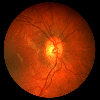

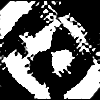

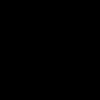

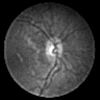

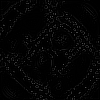

'image = cv2.Canny((image*255).astype(np.uint8),10,20)\nshow_image(image, title="canny")\n'

In [72]:
#rozmycie
gray_to_find_circle = cv2.GaussianBlur(gray_to_find_circle, (5, 5), 0) # medianblur, guassianblur ?
show_image(image, title="blur")
image = cv2.GaussianBlur(image, (35, 35), 0) # medianblur, guassianblur ?

image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

image = cv2.Sobel(image,cv2.CV_64F,1,0,ksize=5)
image = cv2.Sobel(image,cv2.CV_64F,0,1,ksize=5)
show_image(image, "sobel")

image = frangi(image)
show_image(image, title="frangi")

#wyostrzenie
#obraz potrzebny do odnalezienia gałki ocznej
kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
gray_to_find_circle = cv2.filter2D(gray_to_find_circle, -1, kernel)
show_image(gray_to_find_circle, title="filter")

#obraz na którym będziemy dalej pracować
image = cv2.filter2D(image, -1, kernel)
image = cv2.filter2D(image, -1, kernel)
show_image(image, title="filter")

'''image = cv2.Canny((image*255).astype(np.uint8),10,20)
show_image(image, title="canny")
'''
#image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
#show_image(image, "adaptive")


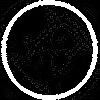

In [73]:
# szukamy gałki ocznej
contours, hierarchy = thresh_show(gray_to_find_circle, 0)

contours_approved = []
(cx, cy) , radius = (0, 0), 0
global approxx
maxArea = 0
for cnt in contours:
    approx = cv2.approxPolyDP(cnt, .03 * cv2.arcLength(cnt, True), True)
    if len(approx) >= 7:
        area = cv2.contourArea(cnt)
        (cx, cy), radius = cv2.minEnclosingCircle(cnt)
        circleArea = radius * radius * np.pi
        if maxArea<area:
            contours_approved = []
            maxArea = area
            contours_approved.append(cnt)
            approxx = approx

# wiodący obraz z konturami gałki ocznej i wypełnieniem
cv2.drawContours(image, contours_approved, -1, (255, 0, 0), 3) 
show_image(image, title="wiodacy obraz z konturami galki ocznej")

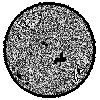

In [75]:
rgb = cv2.cvtColor((image*255).astype(np.uint8), cv2.COLOR_GRAY2RGB)

fill_color = [255, 255, 255]
mask_value = 255 

stencil  = np.zeros(rgb.shape[:-1]).astype(np.uint8)
cv2.fillPoly(stencil, contours_approved, mask_value)

sel      = stencil != mask_value # select everything that is not mask_value
rgb[sel] = fill_color            # and fill it with fill_color

show_image(rgb, title="wiodacy obraz z konturami galki ocznej i wypelnieniem" )

## Właściwe przetworzenie obrazu

In [0]:
def nothing(x):
    pass

def trackbar_thresholds(image):
    cv2.namedWindow('myImage')

    cv2.createTrackbar('threshold1', 'myImage', 0, 255, nothing)
    cv2.createTrackbar('threshold2', 'myImage', 0, 255, nothing)

    
    image2 = image

    while(1):
        cv2.imshow('myImage', image2)
        k = cv2.waitKey(1) & 0xFF
        if k == 27:
            break
        # get current positions of four trackbars
        th1 = cv2.getTrackbarPos('threshold1', 'myImage')
        th2 = cv2.getTrackbarPos('threshold2', 'myImage')
        # canny
        image2 = cv2.Canny(image, th1, th2)
        
    cv2.destroyAllWindows()

In [0]:
image = cv2.cvtColor(rgb, cv2.COLOR_BGR2GRAY)

In [0]:
def threshold(img, threshpoint):
    return np.array([[1 if x >= threshpoint else 0 for x in y] for y in img])

97.28473


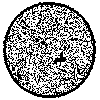

In [79]:
#trackbar_thresholds(image)

#image = cv2.Canny(image, 100, 230)
# wykrywanie krawędzi
#image = frangi(image, black_ridges=True)
image_mean = np.mean(image)

wspol = 0.7 * image_mean - 10 # 0 - 15
print(wspol)

# thresholding
ret,image2 = cv2.threshold(image,wspol, 255, cv2.THRESH_BINARY)
show_image(image2)



## Sprawdzenie

In [81]:
global odp
odp = cv2.imread('/content/drive/My Drive/Colab Notebooks/zdjecia/Image_03R_2ndHO.png')
odp = cv2.resize(odp, (image_size, image_size))
odp = cv2.cvtColor(odp, cv2.COLOR_BGR2GRAY)
ret, odp = cv2.threshold(odp,127, 255, cv2.THRESH_BINARY)
odp = cv2.bitwise_not(odp)

#show_image(odp)
max_val = image_size**2
max_val

10000

In [82]:
np.unique(odp)
#show_image(odp)

array([  0, 255], dtype=uint8)

In [0]:
# white == 255 == not vessel
# black == 0 == vessel
global TP, FP, FN, TN

# true-positve (prawdziwie dodatnie)
# naczynie uznane jako naczynie
def count_TP(actually, result):
    i = 0
    for odp_, res_ in zip(actually, result):
        if (odp_ == 0) and (res_ == 0):
            i += 1
    return i

# false-positive (fałszywie dodatnie)
# nie-naczynie uznane jako naczynie
def count_FP(actually, result):
    
    i = 0
    for odp_, res_ in zip(actually, result):
        if (odp_ == 255) and (res_ == 0):
            i += 1
    return i

# false-negative (fałszywie ujemne)
# naczynie uznane jako nie-naczynie
def count_FN(actually, result):
    i = 0
    for odp_, res_ in zip(actually, result):
        if (odp_ == 0) and (res_ == 255):
            i += 1
    return i

# true-negative (prawdziwie ujemne)
# nie-naczynie uznane jako nie-naczynie
def count_TN(actually, result):
    i = 0
    for odp_, res_ in zip(actually, result):
        if (odp_ == 255) and (res_ == 255):
            i += 1
    return i


In [84]:
TP = count_TP( np.nditer(odp), np.nditer(image2))
print("TP = " + str(TP/max_val))

TP = 0.0248


In [85]:
FP = count_FP( np.nditer(odp), np.nditer(image2))
print("FP = " + str(FP/max_val))

FP = 0.3036


In [86]:
FN = count_FN( np.nditer(odp), np.nditer(image2))
print("FN = " + str(FN/max_val))

FN = 0.0367


In [87]:
TN = count_TN( np.nditer(odp), np.nditer(image2))
print("TN = " + str(TN/max_val))

TN = 0.6349


In [89]:
def confusion_matrix():
    names = {
        'My Results' : ['Positive', 'Negative', 'Sum'],
        'Actually - Positive' : [TP, FN, TP + FN],
        'Actually - Negative' : [FP, TN, FP + TN],
        'Sum' : [TP + FP, FN + TN, TP + FP + FN + TN]
    }
    
    return pd.DataFrame(names, columns=['My Results', 'Actually - Positive', 'Actually - Negative', 'Sum' ]).set_index('My Results')

df_confusion_matrix = confusion_matrix()
df_confusion_matrix

,Actually - Positive,Actually - Negative,Sum
My Results,,,
Positive,248,3036,3284
Negative,367,6349,6716
Sum,615,9385,10000


In [90]:
# trafność
def count_accuracy():
    return (TP + TN)/(TP + TN + FP + FN)
count_accuracy()

0.6597

In [91]:
# czułość
def count_sensitivity():
    return TP/(TP + FN)
count_sensitivity()

0.4032520325203252

In [92]:
# swoistość
def count_specificity():
    return TN/(FP + TN)
count_specificity()

0.6765050612679808

# Część na 5.0

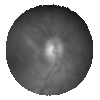

In [42]:
show_image(image)

In [43]:
column_names = ["X", "Y", "Pixel value", "Mean for square", "Max value for square", "Min value for square", "Variance", 
               "Third central moment", #"Image moment", 
                "Right value" ]

global df
df = pd.DataFrame(columns = column_names)
df

,X,Y,Pixel value,Mean for square,Max value for square,Min value for square,Variance,Third central moment,Right value


In [0]:
def workForThisSquare(index, firstCol, firstRow):
    lastRow = firstRow + 5
    lastCol = firstCol + 5
    
    X = firstCol + 2
    Y = firstRow + 2
    PixelValue = image[X, Y]
    
    smallArray = image[firstRow:lastRow, firstCol:lastCol]
    
    MeanForSquare = np.mean(smallArray)
    MaxValueForSquare = np.max(smallArray)
    MinValueForSquare = np.min(smallArray)
    Variance = np.var(smallArray)
    ThirdCentralMoment = moment(smallArray, moment = 3)
    
    RightValue = 0 if odp[X, Y] == 255 else 1
    
    
    df.loc[index] = [X, Y, PixelValue, MeanForSquare, MaxValueForSquare, 
                     MinValueForSquare, Variance, ThirdCentralMoment,RightValue]
    


In [0]:
cols = image.shape[1]
rows = image.shape[0]

i = 0

for c in range(0, cols - 4):
    for r in range(0, rows - 4):
        workForThisSquare(i, c, r)
        i += 1
        

In [46]:
df

,X,Y,Pixel value,Mean for square,Max value for square,Min value for square,Variance,Third central moment,Right value
0,2,2,255,255.0,255,255,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0]",0
1,2,3,255,255.0,255,255,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0]",0
2,2,4,255,255.0,255,255,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0]",0
3,2,5,255,255.0,255,255,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0]",0
4,2,6,255,255.0,255,255,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0]",0
...,...,...,...,...,...,...,...,...,...
9211,97,93,255,255.0,255,255,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0]",0
9212,97,94,255,255.0,255,255,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0]",0
9213,97,95,255,255.0,255,255,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0]",0
9214,97,96,255,255.0,255,255,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0]",0


In [50]:
X_cols = ["Pixel value", "Mean for square", "Max value for square", "Min value for square", "Variance"]
               #"Third central moment"]
y_col = ["Right value"]

X = df[X_cols]
y = df[y_col]

y

,Right value
0,0
1,0
2,0
3,0
4,0
...,...
9211,0
9212,0
9213,0
9214,0


In [0]:
input_shape = X.shape[1]

def build_model():
    return Sequential([
        Dense(32, input_shape=(X.shape[1],), activation='relu'),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

model = build_model()

In [52]:
X_train = X[:7500]
y_train = y[:7500]

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
#metrics.confusion_matrix(y_test, y_pred)
model_history = model.fit(X, y,
          epochs=20,
          batch_size = 20,validation_split=0.20)

ValueError: ignored